In [1]:
!wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc

import fasttext
import numpy as np
import torch
import fasttext
import numpy as np
import torch.nn as nn
import torch.optim as optim
import os
import random
import math
import time
import torchtext
import imp
import tqdm
from torchtext.data import Field, BucketIterator
from nltk.translate.bleu_score import corpus_bleu
import random
import math
import time
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

--2023-05-24 23:49:05--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.08s   

2023-05-24 23:49:06 (163 MB/s) - ‘data.txt’ saved [12905334/12905334]



Блок загрузки данных (стнадратная токенизация по словам и знакам препинания), создание словарей SCR, TRG и оборачивание в BucketIterator

In [2]:
from utils import (
    _len_sort_key
    flatten,
    remove_tech_tokens,
    get_text,
    generate_translation,
    count_parameters
    run
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_W = WordPunctTokenizer()

def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

SRC = Field(tokenize=tokenize,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize=tokenize,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

path_do_data = './data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    path_do_data = './data.txt'

dataset = torchtext.data.TabularDataset(
    path="data.txt",
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key
)

In [3]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of test examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of test examples: 7500


### Эксперимент №1.
Эксперимент основан на модели seq2seq, которая состоит из трёх основных компонентов: энкодера, декодера и модели Seq2Seq, соединяющей оба эти элемента.  
В процессе обучения используется механизм "teacher forcing", со стандартным значением 0.5 (практика показала, что значение очень близко к оптимальному).  Число слоев было подобрано эмпирически: модель не должна переобучаться, при улавливая нетривиальные зависимости в данных.  
В энкодере используется двунаправленная LSTM для более продвинутого учета контекста.

In [6]:
from Seq2Seq import Seq2Seq, Encoder, Decoder
enc = Encoder(
    tokens_num=len(SRC.vocab),
    num_layers=2,
    embedding_dim=128,
    hidden_size=256,
    embedding_dropout=0.1,
    rnn_dropout=0.1
)

dec = Decoder(
    tokens_num=len(TRG.vocab),
    embedding_dim=128,
    embedding_dropout=0.1,
    rnn_dropout=0.1,
    num_layers=2,
    main_hidden_size=256,
)

N_EPOCHS = 10
CLIP = 1

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device, 
                dropout_hidden=0.12, dropout_cell=0.12).to(device)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,610,479 trainable parameters


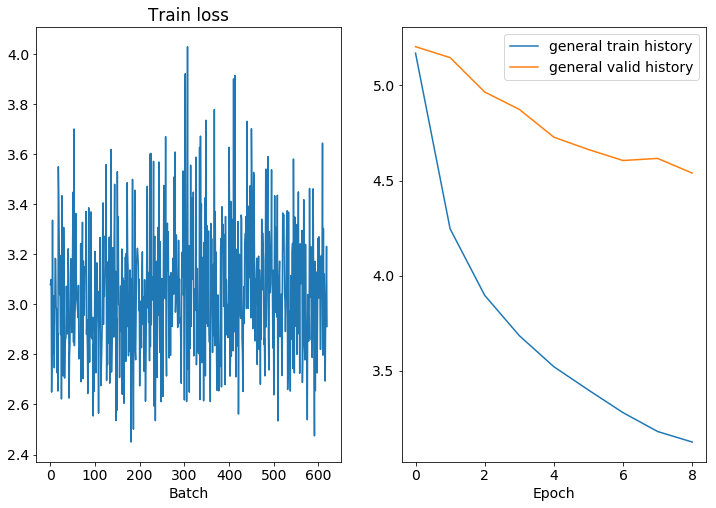

9it [00:00, 81.07it/s]

Epoch: 10 | Time: 1m 19s
	Train Loss: 3.046 | Train PPL:  21.038
	 Val. Loss: 4.546 |  Val. PPL:  94.245


118it [00:02, 54.44it/s]


BLEU SCORE: 16.347935801467838
TIME: 83.11324143409729


In [65]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

run(model, N_EPOCHS, optimizer, criterion, CLIP,
   train_iterator, valid_iterator, test_iterator, TRG)

### Эксперимент 2

Во втором эксперименте применяются предобученные эмбеддинги из модуля fasttext, увеличивается размер скрытых слоев как в энкодере, так и в декодере.

Здесь используются эмбеддинги, которые сгенерированы моделями, обученными на больших корпусах текста (порядка 7 Гб на каждый язык). Ожидаю, что сходиость к оптимуму будет быстрее с получением более точного результата, поскольку предобученные эмбеддинги уже содержат значительные знания о семантике и синтаксисе слов в языке.

In [7]:
import fasttext
import numpy as np

def load_embeddings(embeddings_path, vocab):
    embeddings = fasttext.load_model(embeddings_path)
    embedding_matrix = np.zeros((len(vocab.stoi), embeddings.get_dimension()))
    for word, i in vocab.stoi.items():
        if word in embeddings:
            embedding_matrix[i] = embeddings.get_word_vector(word)
    del embeddings
    return embedding_matrix

In [9]:
en_embeddings_path = '/kaggle/input/embedding/cc.en.300.bin'
ru_embeddings_path = '/kaggle/input/embedding/cc.ru.300.bin'

en_embedding_matrix = load_embeddings(en_embeddings_path, TRG.vocab)
ru_embedding_matrix = load_embeddings(ru_embeddings_path, SRC.vocab)

In [22]:
from Seq2SeqPretrained import Seq2Seq, Encoder, Decoder

enc = Encoder(
    tokens_num=len(SRC.vocab),
    num_layers=2,
    embedding_matrix=ru_embedding_matrix,
    hidden_size=512,
    embedding_dropout=0.1,
    rnn_dropout=0.1
)

dec = Decoder(
    tokens_num=len(TRG.vocab),
    embedding_matrix=en_embedding_matrix,
    embedding_dropout=0.1,
    rnn_dropout=0.1,
    num_layers=2,
    main_hidden_size=1024,
)

N_EPOCHS = 12
CLIP = 1

model = Seq2Seq(enc, dec, device, dropout_hidden=0.12, dropout_cell=0.12).to(device)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 34,596,463 trainable parameters


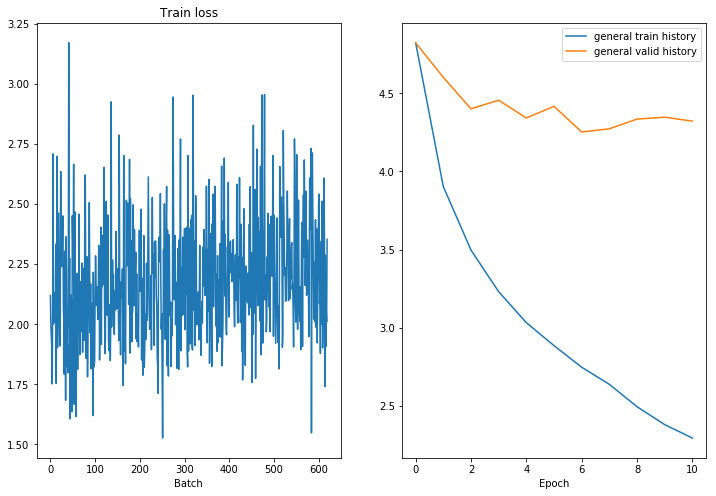

6it [00:00, 54.82it/s]

Epoch: 12 | Time: 2m 19s
	Train Loss: 2.180 | Train PPL:   8.847
	 Val. Loss: 4.435 |  Val. PPL:  84.356


118it [00:03, 32.81it/s]


BLEU SCORE: 21.713474688397806
TIME: 144.5682418346405


In [23]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


run(model, N_EPOCHS, optimizer, criterion, CLIP,
   train_iterator, valid_iterator, test_iterator, TRG)

Как и ожидалось, полученый результат существенно лучше, на 5(!) единиц.

### Эксперимент 3.

В данном эксперименте используется архитектура с механизмом внимания.
В данной реализации веса вычисляются с использованием полносвязного слоя, который принимает на вход вектор, объединяющий скрытое состояние энкодера и декодера. Затем веса внимания нормализуются функцией softmax, чтобы их сумма была равна 1. Таким образом, мы можем интепертировать веса как вероятности, указывающие на то, насколько важен каждый входной элемент для текущего выходного элемента.

В классе Decoder внимание используется для взвешивания скрытых состояний энкодера, и затем полученные взвешенные скрытые состояния объединяются со скрытым состоянием декодера для генерации следующего выходного символа.  

In [55]:
from Seq2SeqAttention import Seq2Seq, Encoder, Decoder

enc = Encoder(
    tokens_num=len(SRC.vocab),
    num_layers=2,
    embedding_matrix=ru_embedding_matrix,
    hidden_size=512,
    embedding_dropout=0.1,
    rnn_dropout=0.1
)

dec = Decoder(
    tokens_num=len(TRG.vocab),
    embedding_matrix=en_embedding_matrix,
    embedding_dropout=0.1,
    rnn_dropout=0.1,
    num_layers=2,
    main_hidden_size=1024,
)

N_EPOCHS = 10
CLIP = 1

model = Seq2Seq(enc, dec, device, dropout_hidden=0.12, dropout_cell=0.12).to(device)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,249,720 trainable parameters


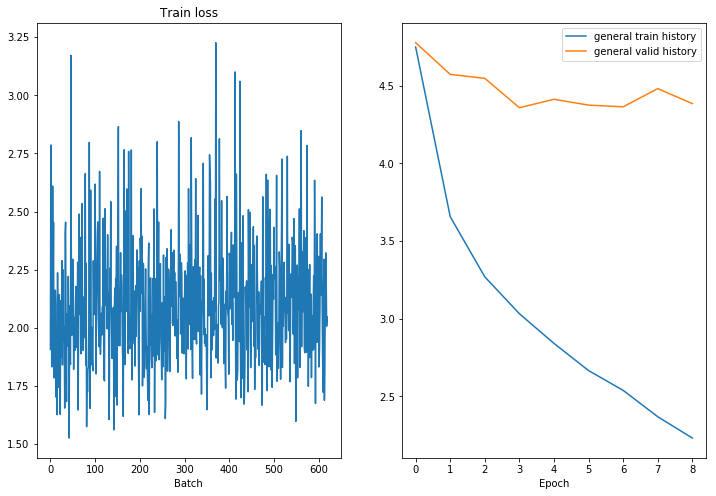

4it [00:00, 34.02it/s]

Epoch: 10 | Time: 4m 38s
	Train Loss: 2.100 | Train PPL:   8.170
	 Val. Loss: 4.518 |  Val. PPL:  91.646


118it [00:08, 13.42it/s]


BLEU SCORE: 23.448099617899203
TIME: 289.4085967540741


In [56]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


run(model, N_EPOCHS, optimizer, criterion, CLIP,
   train_iterator, valid_iterator, test_iterator, TRG)

Был получен существенный прирост метрики BLEU.  
Попробуем увеличить, использовав оптимальную инициализацию весов. 
Ранее она не применялась в экспериментах, так как портит "хороший" график функции val loss.  
Обзор литературы дал понять, что реализация называется "Xavier"
Инициализация Xavier обеспечивает равномерное распределение весов, которое способствует более эффективному распространению градиентов во время обучения.

Из источника: https://www.kaggle.com/code/junkoda/pytorch-lstm-with-tensorflow-like-initialization

In [57]:
class Seq2Seq_Better_init(Seq2Seq):    
    def _reinitialize(self):
            """Tensorflow/Keras-like initialization"""
            for name, p in self.named_parameters():
                if 'lstm' in name:
                    if 'weight ih' in name:
                        nn.init.xavier_uniform_(p.data)
                    elif 'weight hh' in name:
                        nn.init.orthogonal_(p.data)
                    elif 'bias ih' in name:
                        p.data.fill_(0)
                        # Set forget-gate bias to 1
                        n = p.size(0)
                        p.data[(n // 4): (n // 2)].fill_(1)
                    elif 'bias hh' in name:
                        p.data.fill_(O)
                elif 'fc' in name:
                    if 'weight' in name:
                        nn.init.xavier_uniform_(p.data)
                    elif 'bias' in name:
                        p.data.fill_(0)

In [58]:
model = Seq2Seq_Better_init(enc, dec, device, dropout_hidden=0.1, dropout_cell=0.1).to(device)
model._reinitialize()

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,249,720 trainable parameters


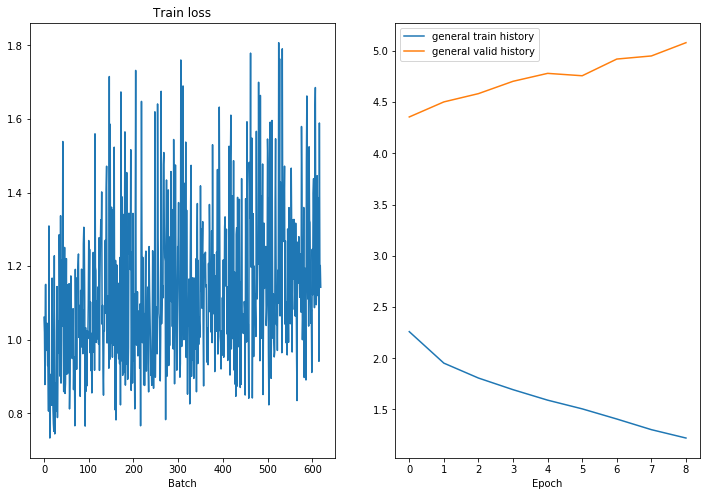

4it [00:00, 34.01it/s]

Epoch: 10 | Time: 4m 41s
	Train Loss: 1.135 | Train PPL:   3.110
	 Val. Loss: 5.262 |  Val. PPL: 192.885


118it [00:08, 13.88it/s]


BLEU SCORE: 24.565392634975087
TIME: 292.14151978492737


In [59]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


main(model, N_EPOCHS, optimizer, criterion, CLIP,
    train_iterator, valid_iterator, test_iterator, TRG)

Итак, получен BLEU ~ 25, что является хорошим результатом. 
Тут мы наблюдаем увеличение метрики BLEU при явном переобучении модели. Почему так происходит?
Гипротеза: Это может быть связано с особенностью BLEU SCORE, который оценивает качество перевода на уровне предложений и учитывает правильность последовательности слов, в то время как функция потерь на уровне отдельных слов может расти. Возможно, модель начинает совершать больше ошибок на уровне отдельных слов, но эти ошибки не сильно влияют на общую структуру предложения и его семантику, что может объяснить увеличение BLEU SCORE.

Итог: был получен ожидамое ранжирование качества результата:
Seq2Seq - Seq2Seq Pretrained -> Seq2Seq pretrained with Attention